In [2]:
import omnicloudmask
import xarray
import numpy
import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

# Read

Sentinel Bands:
- 4: red
- 3: green
- 2: blue
- 8: NIR (10m)

inputs to omnicloud:
- Red (4)
- Green (3)
- NIR  (8)

In [4]:
region = 'UCSB'
ds = xarray.open_zarr(f'/scratch/tristate/{region}_sharp.zarr', consolidated=False)
da = ds['reflectance'].sel(band=['B4', 'B3', 'B8'])
da_rgb = ds['reflectance'].sel(band=['B4', 'B3', 'B2'])

# Interpolate
Omnicloudmask struggles with areas of nans, so we quickly interpolate first

In [5]:
#da = da.interpolate_na(dim='x', method='linear')

# Test run on a time slice

In [108]:
%%time
time = 366
ts = da.isel(time=time).squeeze().compute()
ts_rgb = da_rgb.isel(time=time).squeeze().compute()

CPU times: user 141 ms, sys: 221 ms, total: 362 ms
Wall time: 358 ms


In [109]:
%%time
mask = omnicloudmask.predict_from_array(ts.values, patch_size=920, patch_overlap=300, inference_device='cuda', mosaic_device='cuda')
mask = xarray.DataArray(mask, dims=('time', 'y','x'), coords={'time': np.atleast_1d(ts.time), 'y': da.y, 'x': da.x})

CPU times: user 31.2 s, sys: 2.29 s, total: 33.4 s
Wall time: 278 ms


## Plot outputs

Output classes are defined by the CloudSEN12 paper and dataset used for training.
- 0 = Clear
- 1 = Thick Cloud
- 2 = Thin Cloud
- 3 = Cloud Shadow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01..1.1002918].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01..1.1002918].


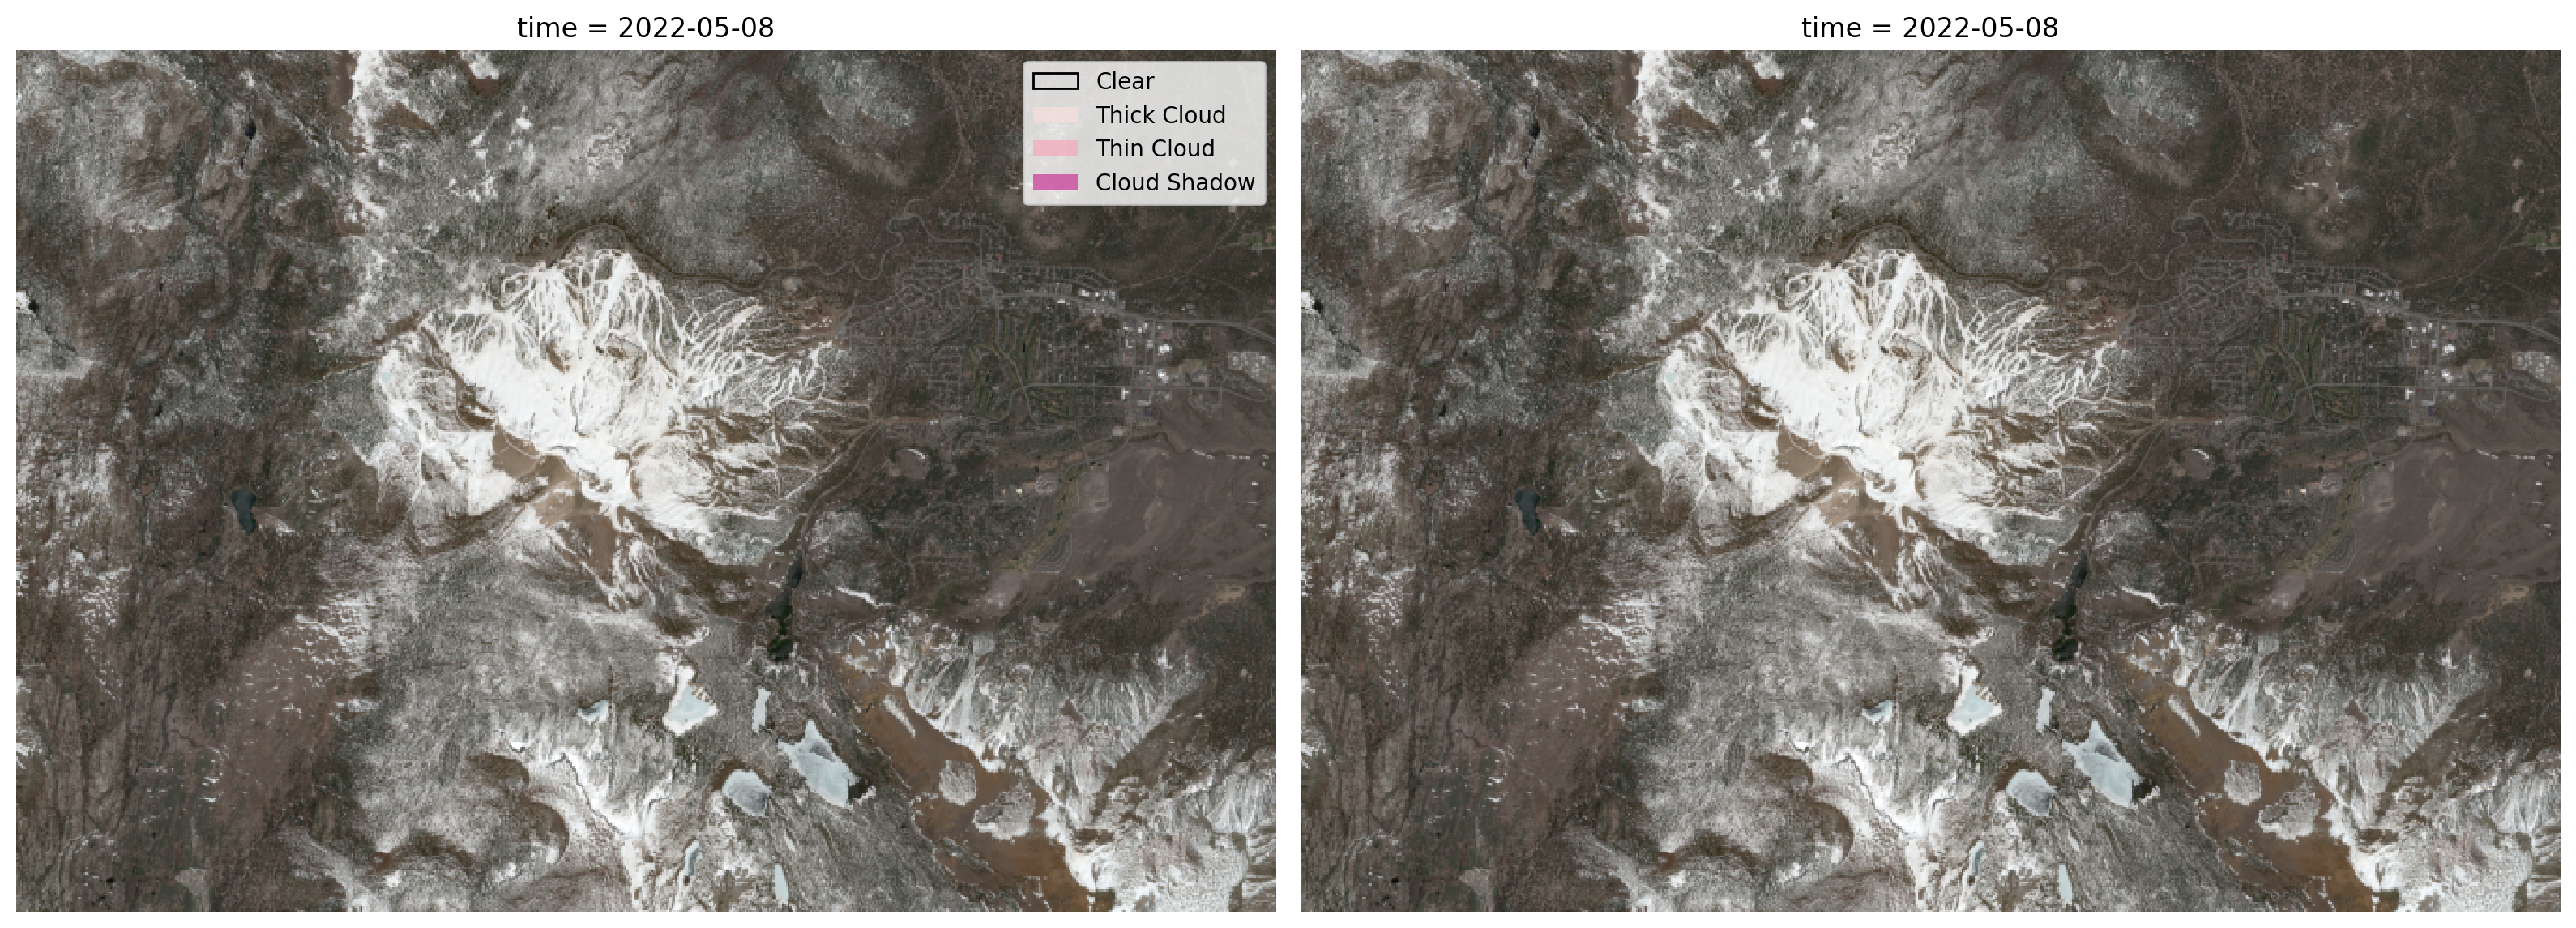

In [110]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

colors = [
    (0, 0, 0, 0),        # Clear -> transparent
    (0xfd/255, 0xe0/255, 0xdd/255, 0.6),  # Thick Cloud
    (0xfa/255, 0x9f/255, 0xb5/255, 0.6),  # Thin Cloud
    (0xc5/255, 0x1b/255, 0x8a/255, 0.6)   # Cloud Shadow
]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=len(colors))

fig, axs = plt.subplots(figsize=(16, 9), dpi=200, ncols=2)

coarse_factor = 2
coarse = (ts_rgb**(1/2)).coarsen(x=coarse_factor, y=coarse_factor, boundary='trim').mean()
im_rgb = coarse.plot.imshow(ax=axs[0])
im_rgb = coarse.plot.imshow(ax=axs[1])

plotable = mask.isel(time=0).coarsen(x=coarse_factor, y=coarse_factor, boundary='trim').mean()
im_cld = plotable.plot.imshow(ax=axs[0], cmap=cmap, norm=norm, alpha=1, add_colorbar=False)

# Add legend
legend_elements = [
    Patch(facecolor='none', edgecolor='black', label='Clear'),
    Patch(facecolor=colors[1], label='Thick Cloud'),
    Patch(facecolor=colors[2], label='Thin Cloud'),
    Patch(facecolor=colors[3], label='Cloud Shadow')
]
axs[0].legend(handles=legend_elements, loc='upper right')

for ax in axs:
    ax.set_aspect('equal')
    ax.axis('off')

fig.tight_layout()
plt.show()

In [80]:
fig.savefig('clouds.png')

# Batch Process

In [ ]:
masks = []
for time in tqdm.tqdm(da['time']):
    ts = da.sel(time=time).squeeze()    
    mask = omnicloudmask.predict_from_array(ts.values, patch_size=920, inference_device='cuda', batch_size=1)
    mask = xarray.DataArray(mask, dims=('time', 'y','x'), coords={'time': np.atleast_1d(ts.time), 'y': da.y, 'x': da.x})
    masks.append(mask)

In [ ]:
%%time
cloudmask = xarray.concat(masks, dim='time')
cloudmask = cloudmask.chunk({'time': ds.chunks['time'], 'y': ds.chunks['y'], 'x': ds.chunks['x']})
cloudmask = cloudmask.to_dataset(name='cloudmask')
cloudmask

In [ ]:
cloudmask.to_zarr(f'/data/sentinel2/zarrs_v3/{region}_cloudmask.zarr', zarr_format=3, consolidated=False, mode='w')

# Read back in

In [ ]:
xarray.open_zarr(f'/data/sentinel2/zarrs_v3/{region}_cloudmask.zarr', consolidated=False)

In [ ]:
1